In [1]:
import numpy as np
from filterpy.common import kinematic_kf
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Initialize the Kalman filter
kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
kf.Q = np.diag([0, 0, .003, .003])
kf.x = np.array([[1., 1., 0., 0.]]).T
kf.R = np.diag([0.03, 0.21])

# Print the initial state
print("Initial state:")
print(kf.x)

Initial state:
[[1.]
 [1.]
 [0.]
 [0.]]


In [2]:
# Simulate measurements
for i in range(101):
    kf.predict()
    kf.update(np.array([[i * 0.05, i * 0.05]]))  # Around 200 kph

# Save the state before the bad measurement
p0 = kf.x[0:2]

# Predict next state
kf.predict()
prior = kf.x

# Introduce a bad measurement
z = kf.x[0:2] * 2
kf.update(z)
p1 = kf.x[0:2]

# Compute error of measurement from prior
y = np.abs(z - kf.H @ prior)
dist = np.linalg.norm(y)

# Print the results
np.set_printoptions(precision=2, suppress=True)
print(f'bad measurement       : {z.T} km')
print(f'before bad measurement: {p0.T} km')
print(f'after bad measurement : {p1.T} km')
print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
print(f'distance from prior   : {dist:.1f} km')

bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km


In [3]:
from filterpy.stats import mahalanobis

# Calculate Mahalanobis distance
def calculate_mahalanobis(x, mean, cov):
    return mahalanobis(x, mean, cov)

# Define gate threshold (e.g., 4 standard deviations)
GATE_THRESHOLD = 4.0

# Compute the Mahalanobis distance
P = kf.P[0:2, 0:2]  # Extract the covariance matrix of the position
m_dist = calculate_mahalanobis(x=z.flatten(), mean=prior[0:2].flatten(), cov=P)

# Gating logic
if m_dist < GATE_THRESHOLD:
    kf.update(z)
    p1 = kf.x[0:2]
    print("Measurement accepted")
else:
    p1 = prior[0:2]
    print("Measurement discarded")

# Compute and print statistics
y = np.abs(z - kf.H @ prior)
dist = np.linalg.norm(y)

print(f'bad measurement       : {z.T} km')
print(f'before bad measurement: {p0.T} km')
print(f'after bad measurement : {p1.T} km')
print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
print(f'distance from prior   : {dist:.1f} km')
print(f'Mahalanobis distance  : {m_dist:.2f}')

Measurement discarded
bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[5.05 5.05]] km
estimate shift        : 0.0 km
distance from prior   : 7.1 km
Mahalanobis distance  : 43.01


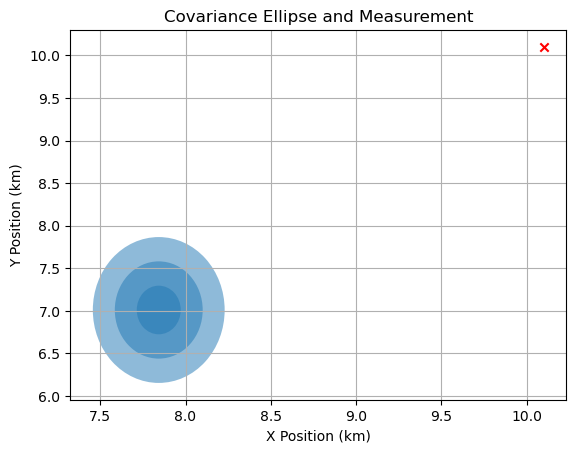

In [4]:
def plot_covariance_ellipse(x, P, std=[1, 2, 3]):
    from matplotlib.patches import Ellipse
    for s in std:
        vals, vecs = np.linalg.eigh(P)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * s * np.sqrt(vals)
        ellipse = Ellipse(xy=x, width=width, height=height, angle=theta, alpha=0.5)
        plt.gca().add_patch(ellipse)

# Plot the covariance ellipse and measurements
x, P = kf.x[0:2], kf.P[0:2, 0:2]
plot_covariance_ellipse(x, P, std=[1, 2, 3])
plt.scatter(z[0], z[1], marker='x', color='red')
plt.title('Covariance Ellipse and Measurement')
plt.xlabel('X Position (km)')
plt.ylabel('Y Position (km)')
plt.grid(True)
plt.show()

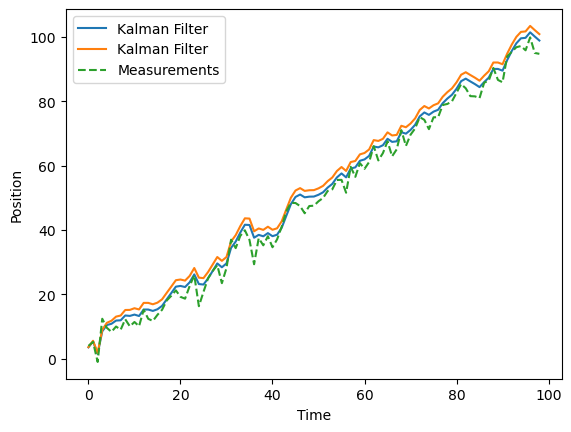

In [5]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
from numpy.random import randn

# Time step
dt = 1.0

# Initialize the Kalman filter
kf = KalmanFilter(dim_x=2, dim_z=1, dim_u=1)
kf.F = np.array([[1., dt], [0., 1.]])  # State transition matrix
kf.B = np.array([[0.5 * dt**2], [dt]])  # Control input matrix
kf.H = np.array([[1., 0]])  # Measurement function
kf.P *= 10  # Covariance matrix
kf.R *= 3  # Measurement noise
kf.Q = np.array([[0.1, 0], [0, 0.1]])  # Process noise

# Commanded velocity (control input)
cmd_velocity = np.array([1.])

# Simulate measurements
zs = [i + randn()*3 for i in range(1, 100)]
xs = []

# Apply the Kalman filter
for z in zs:
    kf.predict(u=cmd_velocity)
    kf.update(z)
    xs.append(kf.x[0])

# Plot results
plt.plot(xs, label='Kalman Filter')
plt.plot(zs, label='Measurements', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(loc='best')
plt.show()

fusion std: 1.647


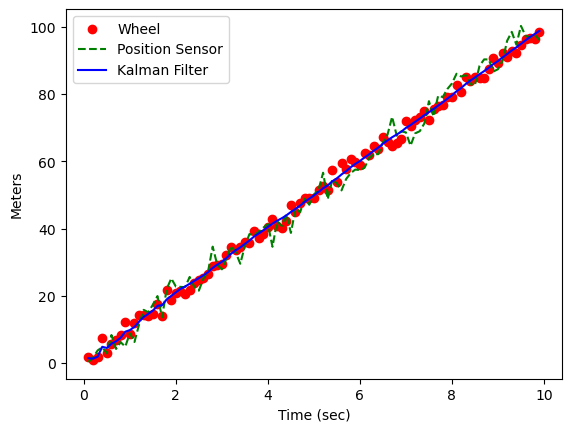

In [6]:
from numpy import array, asarray
import numpy.random as random
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.1
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 
    s = Saver(kf)

    random.seed(1123)
    for i in range(1, 100):
        m0 = i + randn()*wheel_sigma
        m1 = i + randn()*ps_sigma
        kf.predict()
        kf.update(array([[m0], [m1]]))
        s.save()
    s.to_array()
    print(f'fusion std: {np.std(s.y[:, 0]):.3f}')
    if do_plot:
        ts = np.arange(0.1, 10, .1)
        plt.scatter(ts, s.z[:, 0], label='Wheel', color='r')
        plt.plot(ts, s.z[:, 1], ls='--', label='Position Sensor', color='g')
        plt.plot(ts, s.x[:, 0], label='Kalman Filter', color='b')
        plt.legend(loc='best')
        plt.xlabel('Time (sec)')
        plt.ylabel('Meters')
        plt.show()

fusion_test(1.5, 3.0)

Initial state:
[[1.]
 [1.]
 [0.]
 [0.]]
bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km
Measurement discarded
bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[5.05 5.05]] km
estimate shift        : 0.0 km
distance from prior   : 7.1 km
Mahalanobis distance  : 43.01


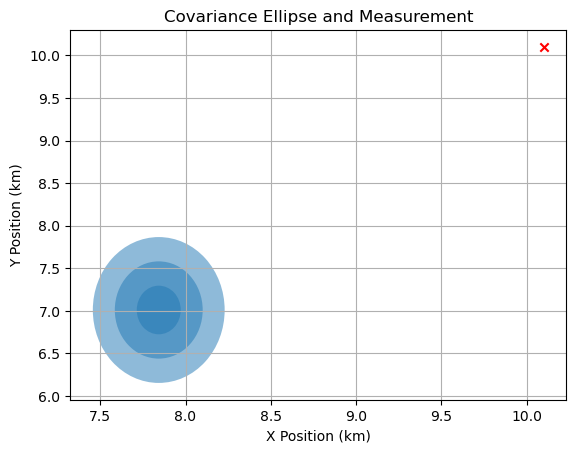

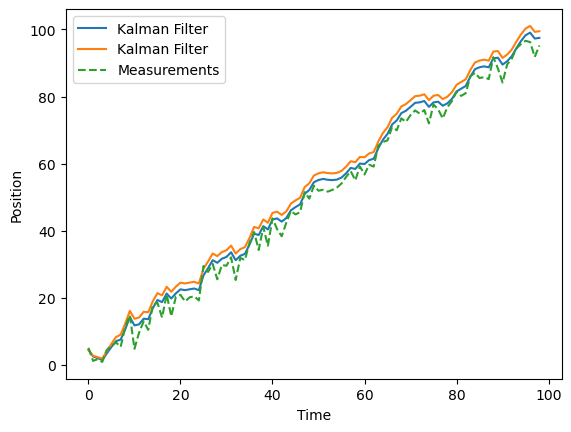

fusion std: 1.647


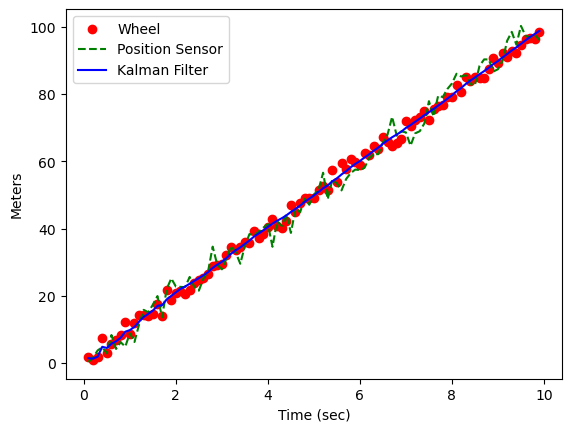

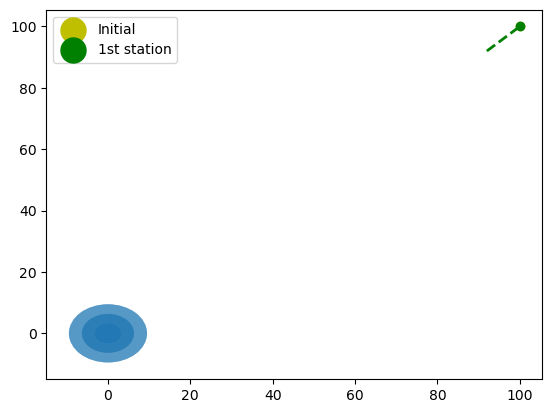

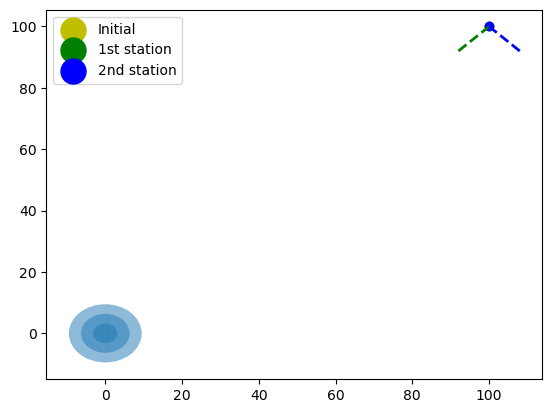

In [7]:
import numpy as np
from filterpy.common import kinematic_kf
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.stats import mahalanobis
from numpy.random import randn
from filterpy.common import Saver


def plot_covariance_ellipse(x, P, std=[1, 2, 3]):
    from matplotlib.patches import Ellipse
    for s in std:
        vals, vecs = np.linalg.eigh(P)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))  # Corrected line
        width, height = 2 * s * np.sqrt(vals)
        ellipse = Ellipse(xy=x[:2], width=width, height=height, angle=theta, alpha=0.5)  # Corrected line
        plt.gca().add_patch(ellipse)


# Section 1: Detecting and Rejecting Bad Measurements
def detect_and_reject_bad_measurement():
    # Initialize the Kalman filter
    kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
    kf.Q = np.diag([0, 0, .003, .003])
    kf.x = np.array([[1., 1., 0., 0.]]).T
    kf.R = np.diag([0.03, 0.21])

    # Print the initial state
    print("Initial state:")
    print(kf.x)

    # Simulate measurements
    for i in range(101):
        kf.predict()
        kf.update(np.array([[i * 0.05, i * 0.05]]))  # Around 200 kph

    # Save the state before the bad measurement
    p0 = kf.x[0:2]

    # Predict next state
    kf.predict()
    prior = kf.x

    # Introduce a bad measurement
    z = kf.x[0:2] * 2
    kf.update(z)
    p1 = kf.x[0:2]

    # Compute error of measurement from prior
    y = np.abs(z - kf.H @ prior)
    dist = np.linalg.norm(y)

    # Print the results
    np.set_printoptions(precision=2, suppress=True)
    print(f'bad measurement       : {z.T} km')
    print(f'before bad measurement: {p0.T} km')
    print(f'after bad measurement : {p1.T} km')
    print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
    print(f'distance from prior   : {dist:.1f} km')

    # Calculate Mahalanobis distance
    def calculate_mahalanobis(x, mean, cov):
        return mahalanobis(x, mean, cov)

    # Define gate threshold (e.g., 4 standard deviations)
    GATE_THRESHOLD = 4.0

    # Compute the Mahalanobis distance
    P = kf.P[0:2, 0:2]  # Extract the covariance matrix of the position
    m_dist = calculate_mahalanobis(x=z.flatten(), mean=prior[0:2].flatten(), cov=P)

    # Gating logic
    if m_dist < GATE_THRESHOLD:
        kf.update(z)
        p1 = kf.x[0:2]
        print("Measurement accepted")
    else:
        p1 = prior[0:2]
        print("Measurement discarded")

    # Compute and print statistics
    y = np.abs(z - kf.H @ prior)
    dist = np.linalg.norm(y)

    print(f'bad measurement       : {z.T} km')
    print(f'before bad measurement: {p0.T} km')
    print(f'after bad measurement : {p1.T} km')
    print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
    print(f'distance from prior   : {dist:.1f} km')
    print(f'Mahalanobis distance  : {m_dist:.2f}')

    # Plot the covariance ellipse and measurements
    x, P = kf.x[0:2], kf.P[0:2, 0:2]
    plot_covariance_ellipse(x, P, std=[1, 2, 3])
    plt.scatter(z[0], z[1], marker='x', color='red')
    plt.title('Covariance Ellipse and Measurement')
    plt.xlabel('X Position (km)')
    plt.ylabel('Y Position (km)')
    plt.grid(True)
    plt.show()

# Section 2: Control Inputs in Kalman Filter
def control_inputs_kalman_filter():
    # Time step
    dt = 1.0

    # Initialize the Kalman filter
    kf = KalmanFilter(dim_x=2, dim_z=1, dim_u=1)
    kf.F = np.array([[1., dt], [0., 1.]])  # State transition matrix
    kf.B = np.array([[0.5 * dt**2], [dt]])  # Control input matrix
    kf.H = np.array([[1., 0]])  # Measurement function
    kf.P *= 10  # Covariance matrix
    kf.R *= 3  # Measurement noise
    kf.Q = np.array([[0.1, 0], [0, 0.1]])  # Process noise

    # Commanded velocity (control input)
    cmd_velocity = np.array([1.])

    # Simulate measurements
    zs = [i + randn()*3 for i in range(1, 100)]
    xs = []

    # Apply the Kalman filter
    for z in zs:
        kf.predict(u=cmd_velocity)
        kf.update(z)
        xs.append(kf.x[0])

    # Plot results
    plt.plot(xs, label='Kalman Filter')
    plt.plot(zs, label='Measurements', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend(loc='best')
    plt.show()

# Section 3: Sensor Fusion with Kalman Filter
def sensor_fusion_kalman_filter():
    def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
        dt = 0.1
        kf = KalmanFilter(dim_x=2, dim_z=2)

        kf.F = np.array([[1., dt], [0., 1.]])
        kf.H = np.array([[1., 0.], [1., 0.]])
        kf.x = np.array([[0.], [1.]])
        kf.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                          [(dt**2)/2,  dt      ]]) * 0.02
        kf.P *= 100
        kf.R[0, 0] = wheel_sigma**2
        kf.R[1, 1] = ps_sigma**2 
        s = Saver(kf)

        random.seed(1123)
        for i in range(1, 100):
            m0 = i + randn()*wheel_sigma
            m1 = i + randn()*ps_sigma
            kf.predict()
            kf.update(np.array([[m0], [m1]]))
            s.save()
        s.to_array()
        print(f'fusion std: {np.std(s.y[:, 0]):.3f}')
        if do_plot:
            ts = np.arange(0.1, 10, .1)
            plt.scatter(ts, s.z[:, 0], label='Wheel', color='r')
            plt.plot(ts, s.z[:, 1], ls='--', label='Position Sensor', color='g')
            plt.plot(ts, s.x[:, 0], label='Kalman Filter', color='b')
            plt.legend(loc='best')
            plt.xlabel('Time (sec)')
            plt.ylabel('Meters')
            plt.show()

    fusion_test(1.5, 3.0)

def radar_sensor_fusion():
    from math import radians

    def sensor_fusion_kf():
        dt = 1.0
        kf = KalmanFilter(dim_x=4, dim_z=2)
        kf.F = np.array([[1., dt, 0., 0.],
                         [0., 1., 0., 0.],
                         [0., 0., 1., dt],
                         [0., 0., 0., 1.]])
        kf.H = np.array([[1., 0., 0., 0.],
                         [0., 0., 1., 0.]])
        kf.P *= 10.
        kf.R *= np.array([[0.5, 0], [0, 0.5]])
        kf.Q = np.eye(4) * 0.1
        return kf

    def set_radar_pos(pos):
        return pos

    kf = sensor_fusion_kf()
    x0, p0 = kf.x.copy(), kf.P.copy()
    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])  # Corrected line

    kf.R[0, 0] = radians(0.5)**2
    kf.R[1, 1] = 3.**2

    set_radar_pos((50, 50))
    dist = (50**2 + 50**2) ** 0.5
    kf.predict()
    kf.update([radians(45), dist])

    x1, p1 = kf.x.copy(), kf.P.copy()
    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])  # Corrected line
    plot_covariance_ellipse(x1[:2], p1[:2, :2], std=[1, 2, 3])  # Corrected line
    plt.scatter([100], [100], c='y', label='Initial')
    plt.scatter([100], [100], c='g', label='1st station')
    plt.legend(scatterpoints=1, markerscale=3)
    plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
    plt.show()

    set_radar_pos((150, 50))
    kf.predict()
    kf.update([radians(135), dist])

    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])  # Corrected line
    plot_covariance_ellipse(x1[:2], p1[:2, :2], std=[1, 2, 3])  # Corrected line
    plot_covariance_ellipse(kf.x[:2], kf.P[:2, :2], std=[1, 2, 3])  # Corrected line
    plt.scatter([100], [100], c='y', label='Initial')
    plt.scatter([100], [100], c='g', label='1st station')
    plt.scatter([100], [100], c='b', label='2nd station')
    plt.legend(scatterpoints=1, markerscale=3)
    plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
    plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--')
    plt.show()


# Execute all sections
detect_and_reject_bad_measurement()
control_inputs_kalman_filter()
sensor_fusion_kalman_filter()
radar_sensor_fusion()

Initial state:
[[1.]
 [1.]
 [0.]
 [0.]]
bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km
Measurement discarded
bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[5.05 5.05]] km
estimate shift        : 0.0 km
distance from prior   : 7.1 km
Mahalanobis distance  : 43.01


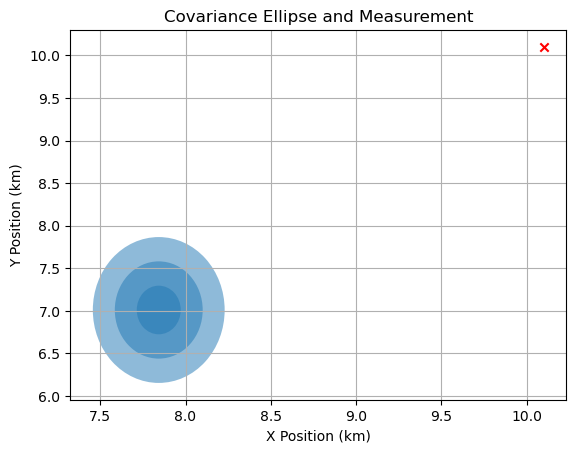

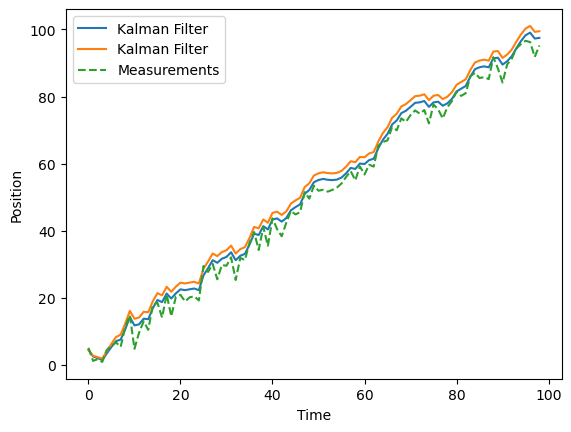

fusion std: 1.647


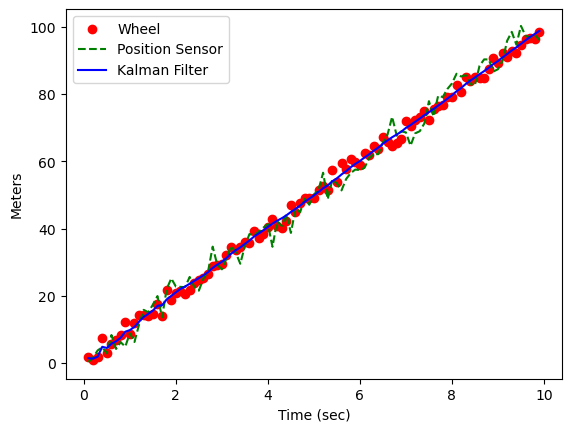

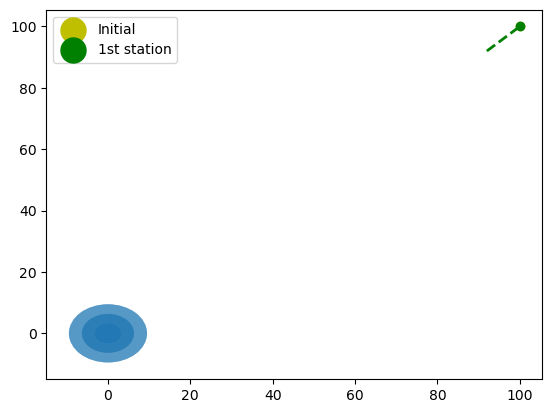

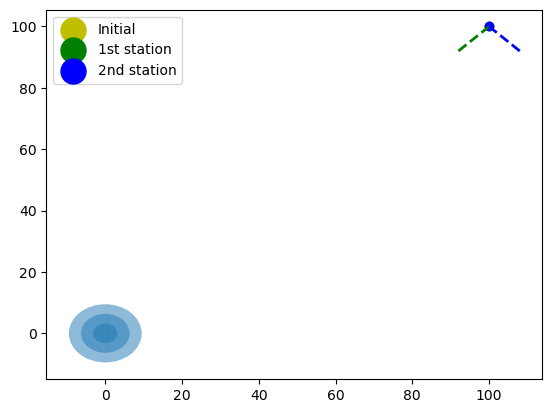

In [8]:
import numpy as np
from filterpy.common import kinematic_kf
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.stats import mahalanobis
from numpy.random import randn
from filterpy.common import Saver

def plot_covariance_ellipse(x, P, std=[1, 2, 3]):
    from matplotlib.patches import Ellipse
    for s in std:
        vals, vecs = np.linalg.eigh(P)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        width, height = 2 * s * np.sqrt(vals)
        ellipse = Ellipse(xy=x[:2], width=width, height=height, angle=theta, alpha=0.5)
        plt.gca().add_patch(ellipse)

# Section 1: Detecting and Rejecting Bad Measurements
def detect_and_reject_bad_measurement():
    # Initialize the Kalman filter
    kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
    kf.Q = np.diag([0, 0, .003, .003])
    kf.x = np.array([[1., 1., 0., 0.]]).T
    kf.R = np.diag([0.03, 0.21])

    # Print the initial state
    print("Initial state:")
    print(kf.x)

    # Simulate measurements
    for i in range(101):
        kf.predict()
        kf.update(np.array([[i * 0.05, i * 0.05]]))  # Around 200 kph

    # Save the state before the bad measurement
    p0 = kf.x[0:2]

    # Predict next state
    kf.predict()
    prior = kf.x

    # Introduce a bad measurement
    z = kf.x[0:2] * 2
    kf.update(z)
    p1 = kf.x[0:2]

    # Compute error of measurement from prior
    y = np.abs(z - kf.H @ prior)
    dist = np.linalg.norm(y)

    # Print the results
    np.set_printoptions(precision=2, suppress=True)
    print(f'bad measurement       : {z.T} km')
    print(f'before bad measurement: {p0.T} km')
    print(f'after bad measurement : {p1.T} km')
    print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
    print(f'distance from prior   : {dist:.1f} km')

    # Calculate Mahalanobis distance
    def calculate_mahalanobis(x, mean, cov):
        return mahalanobis(x, mean, cov)

    # Define gate threshold (e.g., 4 standard deviations)
    GATE_THRESHOLD = 4.0

    # Compute the Mahalanobis distance
    P = kf.P[0:2, 0:2]  # Extract the covariance matrix of the position
    m_dist = calculate_mahalanobis(x=z.flatten(), mean=prior[0:2].flatten(), cov=P)

    # Gating logic
    if m_dist < GATE_THRESHOLD:
        kf.update(z)
        p1 = kf.x[0:2]
        print("Measurement accepted")
    else:
        p1 = prior[0:2]
        print("Measurement discarded")

    # Compute and print statistics
    y = np.abs(z - kf.H @ prior)
    dist = np.linalg.norm(y)

    print(f'bad measurement       : {z.T} km')
    print(f'before bad measurement: {p0.T} km')
    print(f'after bad measurement : {p1.T} km')
    print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
    print(f'distance from prior   : {dist:.1f} km')
    print(f'Mahalanobis distance  : {m_dist:.2f}')

    # Plot the covariance ellipse and measurements
    x, P = kf.x[0:2], kf.P[0:2, 0:2]
    plot_covariance_ellipse(x, P, std=[1, 2, 3])
    plt.scatter(z[0], z[1], marker='x', color='red')
    plt.title('Covariance Ellipse and Measurement')
    plt.xlabel('X Position (km)')
    plt.ylabel('Y Position (km)')
    plt.grid(True)
    plt.show()

# Section 2: Control Inputs in Kalman Filter
def control_inputs_kalman_filter():
    # Time step
    dt = 1.0

    # Initialize the Kalman filter
    kf = KalmanFilter(dim_x=2, dim_z=1, dim_u=1)
    kf.F = np.array([[1., dt], [0., 1.]])  # State transition matrix
    kf.B = np.array([[0.5 * dt**2], [dt]])  # Control input matrix
    kf.H = np.array([[1., 0]])  # Measurement function
    kf.P *= 10  # Covariance matrix
    kf.R *= 3  # Measurement noise
    kf.Q = np.array([[0.1, 0], [0, 0.1]])  # Process noise

    # Commanded velocity (control input)
    cmd_velocity = np.array([1.])

    # Simulate measurements
    zs = [i + randn()*3 for i in range(1, 100)]
    xs = []

    # Apply the Kalman filter
    for z in zs:
        kf.predict(u=cmd_velocity)
        kf.update(z)
        xs.append(kf.x[0])

    # Plot results
    plt.plot(xs, label='Kalman Filter')
    plt.plot(zs, label='Measurements', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend(loc='best')
    plt.show()

# Section 3: Sensor Fusion with Kalman Filter
def sensor_fusion_kalman_filter():
    def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
        dt = 0.1
        kf = KalmanFilter(dim_x=2, dim_z=2)

        kf.F = np.array([[1., dt], [0., 1.]])
        kf.H = np.array([[1., 0.], [1., 0.]])
        kf.x = np.array([[0.], [1.]])
        kf.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                          [(dt**2)/2,  dt      ]]) * 0.02
        kf.P *= 100
        kf.R[0, 0] = wheel_sigma**2
        kf.R[1, 1] = ps_sigma**2 
        s = Saver(kf)

        random.seed(1123)
        for i in range(1, 100):
            m0 = i + randn()*wheel_sigma
            m1 = i + randn()*ps_sigma
            kf.predict()
            kf.update(np.array([[m0], [m1]]))
            s.save()
        s.to_array()
        print(f'fusion std: {np.std(s.y[:, 0]):.3f}')
        if do_plot:
            ts = np.arange(0.1, 10, .1)
            plt.scatter(ts, s.z[:, 0], label='Wheel', color='r')
            plt.plot(ts, s.z[:, 1], ls='--', label='Position Sensor', color='g')
            plt.plot(ts, s.x[:, 0], label='Kalman Filter', color='b')
            plt.legend(loc='best')
            plt.xlabel('Time (sec)')
            plt.ylabel('Meters')
            plt.show()

    fusion_test(1.5, 3.0)

# Section 4: Radar Sensor Fusion with Kalman Filter
def radar_sensor_fusion():
    from math import radians

    def sensor_fusion_kf():
        dt = 1.0
        kf = KalmanFilter(dim_x=4, dim_z=2)
        kf.F = np.array([[1., dt, 0., 0.],
                         [0., 1., 0., 0.],
                         [0., 0., 1., dt],
                         [0., 0., 0., 1.]])
        kf.H = np.array([[1., 0., 0., 0.],
                         [0., 0., 1., 0.]])
        kf.P *= 10.
        kf.R *= np.array([[0.5, 0], [0, 0.5]])
        kf.Q = np.eye(4) * 0.1
        return kf

    def set_radar_pos(pos):
        return pos

    kf = sensor_fusion_kf()
    x0, p0 = kf.x.copy(), kf.P.copy()
    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])

    kf.R[0, 0] = radians(0.5)**2
    kf.R[1, 1] = 3.**2

    set_radar_pos((50, 50))
    dist = (50**2 + 50**2) ** 0.5
    kf.predict()
    kf.update([radians(45), dist])

    x1, p1 = kf.x.copy(), kf.P.copy()
    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])
    plot_covariance_ellipse(x1[:2], p1[:2, :2], std=[1, 2, 3])
    plt.scatter([100], [100], c='y', label='Initial')
    plt.scatter([100], [100], c='g', label='1st station')
    plt.legend(scatterpoints=1, markerscale=3)
    plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
    plt.show()

    set_radar_pos((150, 50))
    kf.predict()
    kf.update([radians(135), dist])

    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])
    plot_covariance_ellipse(x1[:2], p1[:2, :2], std=[1, 2, 3])
    plot_covariance_ellipse(kf.x[:2], kf.P[:2, :2], std=[1, 2, 3])
    plt.scatter([100], [100], c='y', label='Initial')
    plt.scatter([100], [100], c='g', label='1st station')
    plt.scatter([100], [100], c='b', label='2nd station')
    plt.legend(scatterpoints=1, markerscale=3)
    plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
    plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--')
    plt.show()

# Execute all sections
detect_and_reject_bad_measurement()
control_inputs_kalman_filter()
sensor_fusion_kalman_filter()
radar_sensor_fusion()


Initial state:
[[1.]
 [1.]
 [0.]
 [0.]]
Introduced bad measurement: [10.1 10.1]
bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km
Measurement discarded
bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[5.05 5.05]] km
estimate shift        : 0.0 km
distance from prior   : 7.1 km
Mahalanobis distance  : 43.01


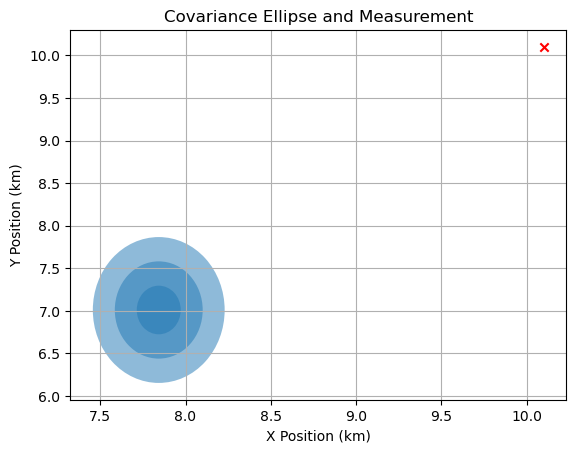

Final state: [97.48 99.47  1.64  2.91]
Final covariance matrix: 
[[1.41 0.4 ]
 [0.4  0.35]]


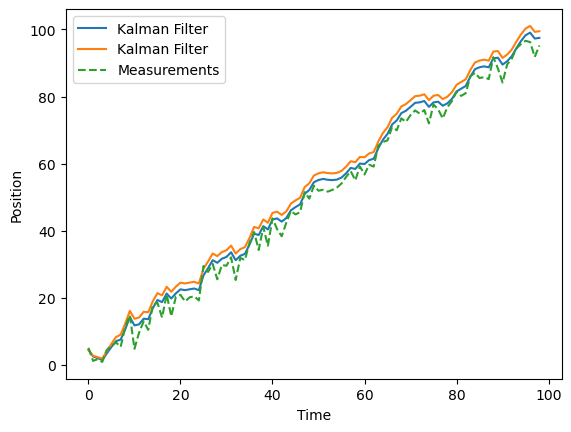

fusion std: 1.744


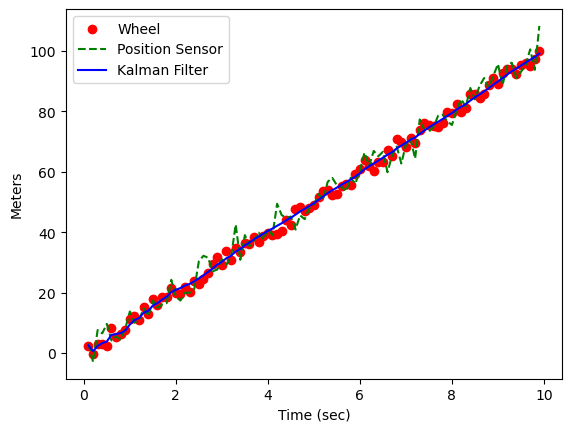

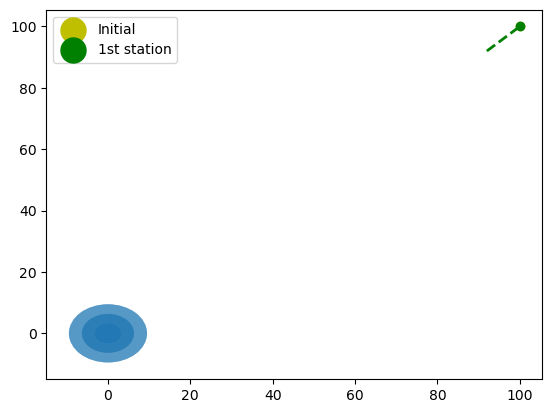

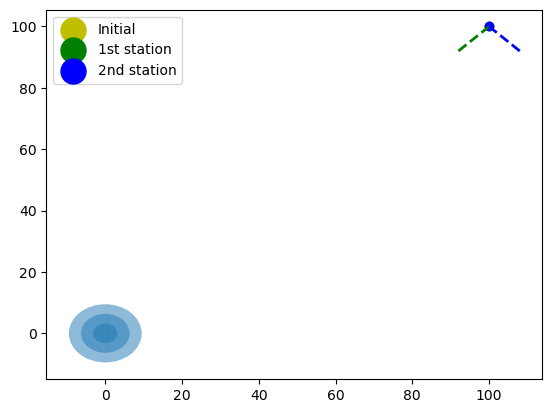

In [9]:
import numpy as np
from filterpy.common import kinematic_kf
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.stats import mahalanobis
from numpy.random import randn
from filterpy.common import Saver

def plot_covariance_ellipse(x, P, std=[1, 2, 3]):
    from matplotlib.patches import Ellipse
    for s in std:
        vals, vecs = np.linalg.eigh(P)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        width, height = 2 * s * np.sqrt(vals)
        ellipse = Ellipse(xy=x[:2], width=width, height=height, angle=theta, alpha=0.5)
        plt.gca().add_patch(ellipse)

def detect_and_reject_bad_measurement():
    # Initialize the Kalman filter
    kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
    kf.Q = np.diag([0, 0, .003, .003])
    kf.x = np.array([[1., 1., 0., 0.]]).T
    kf.R = np.diag([0.03, 0.21])

    # Print the initial state
    print("Initial state:")
    print(kf.x)

    # Simulate measurements
    for i in range(101):
        kf.predict()
        measurement = np.array([[i * 0.05, i * 0.05]])
        kf.update(measurement)

    # Save the state before the bad measurement
    p0 = kf.x[0:2]

    # Predict next state
    kf.predict()
    prior = kf.x

    # Introduce a bad measurement
    z = kf.x[0:2] * 2
    print(f'Introduced bad measurement: {z.flatten()}')

    # Update with the bad measurement
    kf.update(z)
    p1 = kf.x[0:2]

    # Compute error of measurement from prior
    y = np.abs(z - kf.H @ prior)
    dist = np.linalg.norm(y)

    # Print the results
    np.set_printoptions(precision=2, suppress=True)
    print(f'bad measurement       : {z.T} km')
    print(f'before bad measurement: {p0.T} km')
    print(f'after bad measurement : {p1.T} km')
    print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
    print(f'distance from prior   : {dist:.1f} km')

    # Calculate Mahalanobis distance
    P = kf.P[0:2, 0:2]  # Extract the covariance matrix of the position
    m_dist = calculate_mahalanobis(x=z.flatten(), mean=prior[0:2].flatten(), cov=P)

    # Gating logic
    GATE_THRESHOLD = 4.0
    if m_dist < GATE_THRESHOLD:
        kf.update(z)
        p1 = kf.x[0:2]
        print("Measurement accepted")
    else:
        p1 = prior[0:2]
        print("Measurement discarded")

    # Compute and print statistics
    y = np.abs(z - kf.H @ prior)
    dist = np.linalg.norm(y)

    print(f'bad measurement       : {z.T} km')
    print(f'before bad measurement: {p0.T} km')
    print(f'after bad measurement : {p1.T} km')
    print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
    print(f'distance from prior   : {dist:.1f} km')
    print(f'Mahalanobis distance  : {m_dist:.2f}')

    # Plot the covariance ellipse and measurements
    x, P = kf.x[0:2], kf.P[0:2, 0:2]
    plot_covariance_ellipse(x, P, std=[1, 2, 3])
    plt.scatter(z[0], z[1], marker='x', color='red')
    plt.title('Covariance Ellipse and Measurement')
    plt.xlabel('X Position (km)')
    plt.ylabel('Y Position (km)')
    plt.grid(True)
    plt.show()

def control_inputs_kalman_filter():
    dt = 1.0
    kf = KalmanFilter(dim_x=2, dim_z=1, dim_u=1)
    kf.F = np.array([[1., dt], [0., 1.]])
    kf.B = np.array([[0.5 * dt**2], [dt]])
    kf.H = np.array([[1., 0]])
    kf.P *= 10
    kf.R *= 3
    kf.Q = np.array([[0.1, 0], [0, 0.1]])

    cmd_velocity = np.array([1.])

    zs = [i + randn()*3 for i in range(1, 100)]
    xs = []

    for z in zs:
        kf.predict(u=cmd_velocity)
        kf.update(z)
        xs.append(kf.x[0])

    # Print final and initial states
    print(f'Final state: {kf.x.flatten()}')
    print(f'Final covariance matrix: \n{kf.P}')

    plt.plot(xs, label='Kalman Filter')
    plt.plot(zs, label='Measurements', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend(loc='best')
    plt.show()


def sensor_fusion_kalman_filter():
    def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
        dt = 0.1
        kf = KalmanFilter(dim_x=2, dim_z=2)

        kf.F = np.array([[1., dt], [0., 1.]])
        kf.H = np.array([[1., 0.], [1., 0.]])
        kf.x = np.array([[0.], [1.]])
        kf.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                          [(dt**2)/2,  dt      ]]) * 0.02
        kf.P *= 100
        kf.R[0, 0] = wheel_sigma**2
        kf.R[1, 1] = ps_sigma**2
        s = Saver(kf)

        for i in range(1, 100):
            m0 = i + randn()*wheel_sigma
            m1 = i + randn()*ps_sigma
            kf.predict()
            kf.update(np.array([[m0], [m1]]))
            s.save()
        
        s.to_array()
        print(f'fusion std: {np.std(s.y[:, 0]):.3f}')

        if do_plot:
            ts = np.arange(0.1, 10, .1)
            plt.scatter(ts, s.z[:, 0], label='Wheel', color='r')
            plt.plot(ts, s.z[:, 1], ls='--', label='Position Sensor', color='g')
            plt.plot(ts, s.x[:, 0], label='Kalman Filter', color='b')
            plt.legend(loc='best')
            plt.xlabel('Time (sec)')
            plt.ylabel('Meters')
            plt.show()

    fusion_test(1.5, 3.0)


def radar_sensor_fusion():
    from math import radians

    def sensor_fusion_kf():
        dt = 1.0
        kf = KalmanFilter(dim_x=4, dim_z=2)
        kf.F = np.array([[1., dt, 0., 0.],
                         [0., 1., 0., 0.],
                         [0., 0., 1., dt],
                         [0., 0., 0., 1.]])
        kf.H = np.array([[1., 0., 0., 0.],
                         [0., 0., 1., 0.]])
        kf.P *= 10.
        kf.R *= np.array([[0.5, 0], [0, 0.5]])
        kf.Q = np.eye(4) * 0.1
        return kf

    def set_radar_pos(pos):
        return pos

    kf = sensor_fusion_kf()
    x0, p0 = kf.x.copy(), kf.P.copy()
    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])

    kf.R[0, 0] = radians(0.5)**2
    kf.R[1, 1] = 3.**2

    set_radar_pos((50, 50))
    dist = (50**2 + 50**2) ** 0.5
    kf.predict()
    kf.update([radians(45), dist])

    x1, p1 = kf.x.copy(), kf.P.copy()
    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])
    plot_covariance_ellipse(x1[:2], p1[:2, :2], std=[1, 2, 3])
    plt.scatter([100], [100], c='y', label='Initial')
    plt.scatter([100], [100], c='g', label='1st station')
    plt.legend(scatterpoints=1, markerscale=3)
    plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
    plt.show()

    set_radar_pos((150, 50))
    kf.predict()
    kf.update([radians(135), dist])

    plot_covariance_ellipse(x0[:2], p0[:2, :2], std=[1, 2, 3])
    plot_covariance_ellipse(x1[:2], p1[:2, :2], std=[1, 2, 3])
    plot_covariance_ellipse(kf.x[:2], kf.P[:2, :2], std=[1, 2, 3])
    plt.scatter([100], [100], c='y', label='Initial')
    plt.scatter([100], [100], c='g', label='1st station')
    plt.scatter([100], [100], c='b', label='2nd station')
    plt.legend(scatterpoints=1, markerscale=3)
    plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
    plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--')
    plt.show()


# Execute all sections
detect_and_reject_bad_measurement()
control_inputs_kalman_filter()
sensor_fusion_kalman_filter()
radar_sensor_fusion()
